# Proyecto Machine Learning
+ # Bank Customer Churn Detection
+ ## **Modelos Basline:**: "Churn_processed.csv"

Librerías necesarias:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import pickle
import yaml

Leemos el Dataset de "Train_churn_processed.csv"

In [2]:
df_train = pd.read_csv("../data_processed/Train_Churn_processed.csv")
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Exited
0,619,0,1,42,2,0.00,1,1,1,101348.88,2,0,464,1
1,608,1,1,41,1,83807.86,1,0,1,112542.58,3,0,456,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,3,0,377,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,5,1,350,0
4,850,1,1,43,2,125510.82,1,1,1,79084.10,5,1,425,0


Sacamos X e y . Además, dividimos en train y test:

In [3]:
X = df_train.drop(columns=["Exited"])
y = df_train["Exited"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print("Total features shape:", X.shape)
print("Train features shape:", X_train.shape)
print("Train target shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test target shape:", y_test.shape)

Total features shape: (10000, 13)
Train features shape: (8000, 13)
Train target shape: (8000,)
Test features shape: (2000, 13)
Test target shape: (2000,)


In [5]:
print("Distribución del Target en y:\n", y.value_counts(normalize=True))
print("-"*35)
print("Distribución del Target en y_train:\n", y_train.value_counts(normalize=True))
print("-"*35)
print("Distribución del Target en y_test:\n", y_test.value_counts(normalize=True))

Distribución del Target en y:
 Exited
0    0.7962
1    0.2038
Name: proportion, dtype: float64
-----------------------------------
Distribución del Target en y_train:
 Exited
0    0.798
1    0.202
Name: proportion, dtype: float64
-----------------------------------
Distribución del Target en y_test:
 Exited
0    0.789
1    0.211
Name: proportion, dtype: float64


Modelos: 
1. Logistic Regression
2. Random Forest Classifier
3. SVC

1. Logistic Regression

In [6]:
reg_log = Pipeline(steps = [
    ("scaler", StandardScaler()),
    ("reglog", LogisticRegression())
])

reg_log_param = {
    "reglog__penalty": ['l2', 'none'],
    "reglog__C": np.logspace(0, 4, 10)}

gs_reg_log = GridSearchCV(reg_log,
                         reg_log_param,
                         cv = 10,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_reg_log.fit(X_train, y_train)

print(gs_reg_log.best_score_)
print(gs_reg_log.best_params_)
print(gs_reg_log.best_estimator_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
0.2153477494057204
{'reglog__C': 1.0, 'reglog__penalty': 'l2'}
Pipeline(steps=[('scaler', StandardScaler()), ('reglog', LogisticRegression())])


In [7]:
final_model = gs_reg_log.best_estimator_
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

In [8]:
print("accuracy_score", accuracy_score(y_test, y_pred))
print("precision_score", precision_score(y_test, y_pred))
print("recall_score", recall_score(y_test, y_pred))
print("roc_auc_score", roc_auc_score(y_test, y_pred))
print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

accuracy_score 0.8025
precision_score 0.6015037593984962
recall_score 0.1895734597156398
roc_auc_score 0.5779933204788592
confusion_matrix
 [[1525   53]
 [ 342   80]]


2. Random Forest Classifier

In [9]:
rnf_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", RandomForestClassifier())
])

rnf_param = {
    "selectkbest__k": [1, 2, 3], 
    "classifier__n_estimators": [10, 100, 1000],
    "classifier__max_features": [1, 2, 3]
}

gs_rnf = GridSearchCV(rnf_pipe,
                         rnf_param,
                         cv = 10,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_rnf.fit(X_train, y_train)

print(gs_rnf.best_score_)
print(gs_rnf.best_params_)
print(gs_rnf.best_estimator_)

Fitting 10 folds for each of 27 candidates, totalling 270 fits
0.32115251897860597
{'classifier__max_features': 1, 'classifier__n_estimators': 100, 'selectkbest__k': 3}
Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=3)),
                ('classifier', RandomForestClassifier(max_features=1))])


In [10]:
final_model = gs_rnf.best_estimator_
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("accuracy_score", accuracy_score(y_test, y_pred))
print("precision_score", precision_score(y_test, y_pred))
print("recall_score", recall_score(y_test, y_pred))
print("roc_auc_score", roc_auc_score(y_test, y_pred))
print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

accuracy_score 0.8235
precision_score 0.6994219653179191
recall_score 0.28672985781990523
roc_auc_score 0.626888376311727
confusion_matrix
 [[1526   52]
 [ 301  121]]


3. SVC

In [11]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()),
    ("classifier", SVC())
])

svm_params = {
    'selectkbest__k':np.arange(5,10),
    'classifier': [SVC()],
    'classifier__C': [0.1,1,10]
}
gs_svc = GridSearchCV(rnf_pipe,
                         svm_params,
                         cv = 4,
                         scoring = 'recall',
                         verbose = 1,
                         n_jobs = -1)

gs_svc.fit(X_train, y_train)

print(gs_svc.best_score_)
print(gs_svc.best_params_)
print(gs_svc.best_estimator_)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
0.45049504950495045
{'classifier': SVC(), 'classifier__C': 10, 'selectkbest__k': 9}
Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=9)),
                ('classifier', SVC(C=10))])


In [12]:
final_model = gs_svc.best_estimator_
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

print("accuracy_score", accuracy_score(y_test, y_pred))
print("precision_score", precision_score(y_test, y_pred))
print("recall_score", recall_score(y_test, y_pred))
print("roc_auc_score", roc_auc_score(y_test, y_pred))
print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

accuracy_score 0.848
precision_score 0.7458333333333333
recall_score 0.42417061611374407
roc_auc_score 0.6927570444320305
confusion_matrix
 [[1517   61]
 [ 243  179]]


Abormdamos el problema del desbalance de los datos en el target "Exited":

1. Submuestreo (Undersampling):
Esta estrategia implica reducir la cantidad de instancias de la clase mayoritaria (en este caso, 0) para igualarla con la cantidad de instancias de la clase minoritaria (en este caso, 1).

2. Nos centraremos en el scoring de "recall": 
Mide la proporción de instancias positivas correctamente clasificadas entre todas las instancias que realmente son positivas. En este caso, el costo de los falsos negativos es alto y queremos identificar la mayor cantidad posible de casos positivos.

In [13]:
rus = RandomUnderSampler(random_state=10)

X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [14]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("selectkbest", SelectKBest()), 
    ("classifier", RandomForestClassifier())
])
log_params = {
    'selectkbest__k':np.arange(5,13),
    'classifier': [LogisticRegression()],
    'classifier__C': [0.1,1,10]
}
rf_params = {
    'scaler': [StandardScaler(), None],
    'selectkbest__k':np.arange(5,13),
    'classifier': [RandomForestClassifier()],
    'classifier__max_depth': [3,5,7]
}

knn_params = {
    'selectkbest__k':np.arange(5,13),
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': np.arange(5,15)
}
svm_params = {
    'selectkbest__k':np.arange(5,13),
    'classifier': [SVC()],
    'classifier__C': [0.1,1,10]
}
search_space = [
    log_params,
    rf_params,
    knn_params,
    svm_params   
]


In [15]:
clf_gs = GridSearchCV(estimator=pipe, param_grid=search_space, cv=10, scoring="recall", verbose=3, n_jobs=-1)
clf_gs.fit(X_train_resampled, y_train_resampled)

print(clf_gs.best_estimator_)
print(clf_gs.best_score_)
print(clf_gs.best_params_)

final_model_gs = clf_gs.best_estimator_
final_model_gs.fit(X_train_resampled, y_train_resampled)
y_pred = final_model_gs.predict(X_test)

print("accuracy_score", accuracy_score(y_test, y_pred))
print("precision_score", precision_score(y_test, y_pred))
print("recall_score", recall_score(y_test, y_pred))
print("roc_auc_score", roc_auc_score(y_test, y_pred))
print("confusion_matrix\n", confusion_matrix(y_test, y_pred))

Fitting 10 folds for each of 176 candidates, totalling 1760 fits
Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=6)),
                ('classifier', SVC(C=0.1))])
0.7630051376428189
{'classifier': SVC(), 'classifier__C': 0.1, 'selectkbest__k': 6}
accuracy_score 0.7735
precision_score 0.4767616191904048
recall_score 0.7535545023696683
roc_auc_score 0.7661942347082816
confusion_matrix
 [[1229  349]
 [ 104  318]]


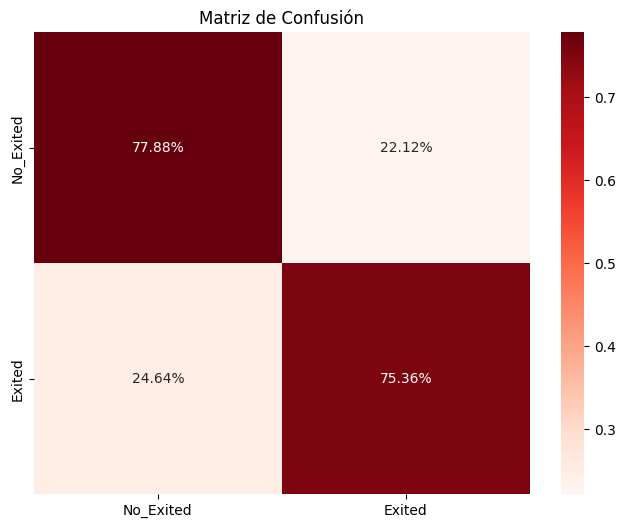

In [16]:
conf_matrix_test = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt=".2%", cmap='Reds', xticklabels=['No_Exited', 'Exited'], yticklabels=['No_Exited', 'Exited'])
plt.title('Matriz de Confusión');

Probamos en "Test_Churn_processed.cs"

In [17]:
df_test = pd.read_csv("../data_processed/Test_Churn_processed.csv")
df_test.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Card Type,Point Earned,Exited
0,747,2,0,36,8,102603.30,2,1,1,180693.61,3,1,751,0
1,707,1,0,32,9,0.00,2,1,0,126475.79,2,2,947,0
2,590,1,0,37,1,0.00,2,0,0,133535.99,2,1,930,0
3,603,1,0,57,6,105000.85,2,1,1,87412.24,3,0,281,1
4,615,0,0,45,5,0.00,2,1,1,164886.64,4,0,537,0


In [18]:
X_t = df_test.drop(columns=["Exited"])
y_t = df_test["Exited"]

In [19]:
y_pred_test = final_model_gs.predict(X_t)
y_pred_test

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [20]:
X_t.shape

(2000, 13)

In [21]:
y_t.shape

(2000,)

In [22]:
print("accuracy_score", accuracy_score(y_pred_test, y_t))
print("precision_score", precision_score(y_pred_test, y_t))
print("recall_score", recall_score(y_pred_test, y_t))
print("roc_auc_score", roc_auc_score(y_pred_test, y_t))
print("confusion_matrix\n", confusion_matrix(y_pred_test, y_t))

accuracy_score 0.7755
precision_score 0.7263427109974424
recall_score 0.4536741214057508
roc_auc_score 0.68789965167813
confusion_matrix
 [[1267  107]
 [ 342  284]]


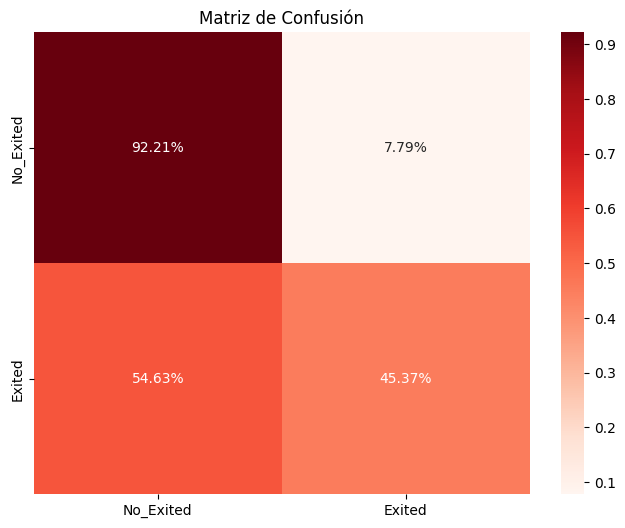

In [23]:
conf_matrix_test = confusion_matrix(y_pred_test, y_t, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt=".2%", cmap='Reds', xticklabels=['No_Exited', 'Exited'], yticklabels=['No_Exited', 'Exited'])
plt.title('Matriz de Confusión');

Guardamos el modelo:

In [24]:
filename = 'finished_model_gs'

with open(filename, 'wb') as archivo_salida:
    pickle.dump(final_model_gs, archivo_salida)

In [25]:
model_info = {'classifier': SVC(), 
              'classifier__C': 0.1, 
              'selectkbest__k': 6}

with open('final_model_gs.yaml', 'w') as yaml_file:
    yaml.dump(model_info, yaml_file)

In [26]:
with open(filename, 'rb') as archivo_entrada:
    modelo_importado = pickle.load(archivo_entrada)

In [27]:
modelo_importado

Pipeline(steps=[('scaler', StandardScaler()), ('selectkbest', SelectKBest(k=6)),
                ('classifier', SVC(C=0.1))])